### Library

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import Module
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
import os
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Download Path

In [2]:
Download_DataPath = os.path.join(os.getcwd(),'Data')

### Load  - Transoform - Normalize MINST Dateset

In [3]:
transform = transforms.Compose([transforms.Resize((28, 28)) ,transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
training_dataset = datasets.MNIST(root = Download_DataPath, train = True, transform = transform, download = True)
validation_dataset = datasets.MNIST(root = Download_DataPath, train = False, transform = transform, download = True)

### Prepare - Shuffle Data Batches

In [4]:
training_loader = DataLoader(dataset = training_dataset, shuffle = True, batch_size = 100)
validation_loader = DataLoader(dataset = validation_dataset, shuffle = True, batch_size = 100)

#### Transofrom Tesnor Image
- Tensor Image Of Shape (1, 28, 28) to (28, 28, 1)
- Remove Normalization
- Set Value Range From 0 -> 1 Instead Of -1 -> 1

In [5]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy() # Get Clone From The Tensor And Transfer To Numpy Array
    image = image.transpose(1, 2, 0) # Fix ARray Shape From (1, 28, 28) to (28, 28, 1) To Be Feeded Well To The Network ( Model )
    #print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # Remove Normalization
    image = image.clip(0, 1) # Clip Every -1 to 0 and Every 1 to 1 In The Array
    return image

### Load Data In Batches

In [6]:
dataIter = iter(training_loader) # Move Through Data Batches 
images, labels = next(dataIter) #( Load Batche One By One Mean Load Every 100 Image )

In [7]:
valdataIter = iter(validation_loader) # Move Through Data Batches 
vimages, vlabels = next(valdataIter) #( Load Batche One By One Mean Load Every 100 Image )

### Plot First 20 Image

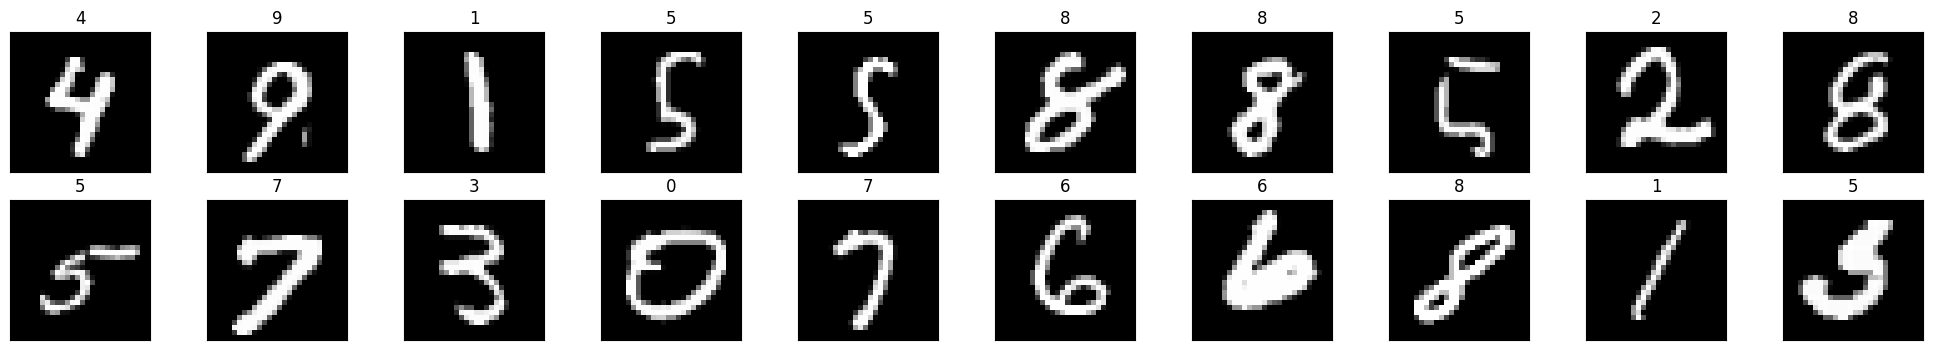

In [8]:
fig = plt.figure(figsize = (25, 4))
for idx in range(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(labels[idx].item())

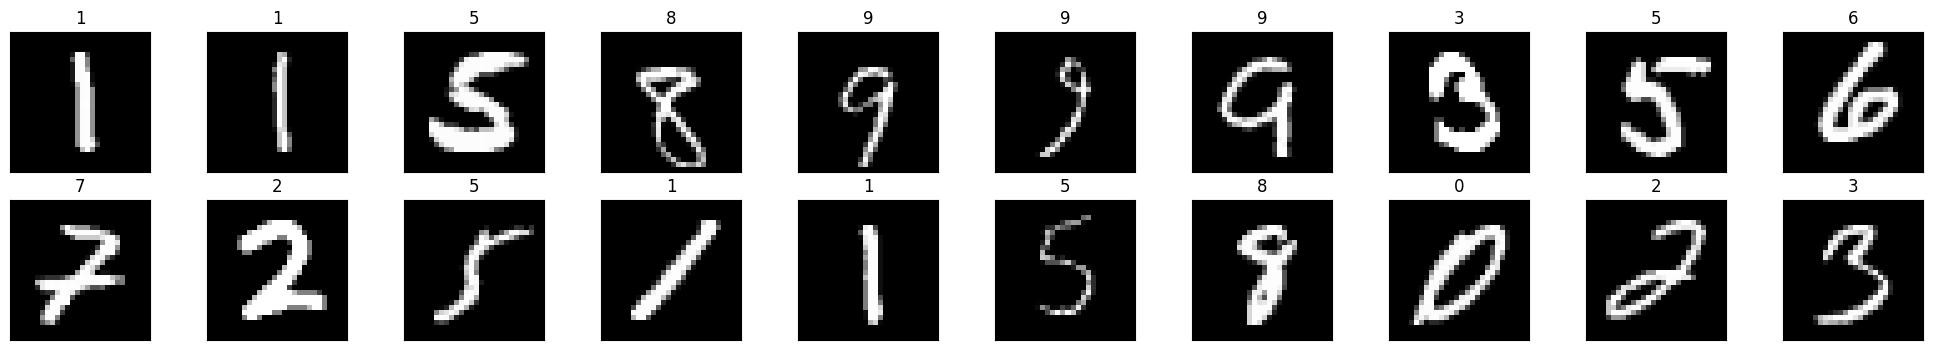

In [9]:
fig = plt.figure(figsize = (25, 4))
for idx in range(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
    plt.imshow(im_convert(vimages[idx]))
    ax.set_title(vlabels[idx].item())

### Create Model

In [10]:
class ImageClassifier(Module):
    def __init__(self, input_size, h1_size, h2_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(in_features = input_size, out_features = h1_size)
        self.linear2 = nn.Linear(in_features = h1_size, out_features = h2_size)
        self.linear3 = nn.Linear(in_features = h2_size, out_features = output_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [11]:
model = ImageClassifier(input_size = 784, h1_size = 125, h2_size = 65, output_size = 10)

In [12]:
model.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.0203,  0.0289,  0.0118,  ..., -0.0115,  0.0047,  0.0285],
                      [ 0.0117,  0.0029,  0.0106,  ...,  0.0174,  0.0311,  0.0131],
                      [-0.0280, -0.0062,  0.0074,  ..., -0.0179, -0.0187, -0.0099],
                      ...,
                      [-0.0323, -0.0122,  0.0158,  ...,  0.0071, -0.0273,  0.0256],
                      [ 0.0271, -0.0067, -0.0348,  ..., -0.0331, -0.0329,  0.0132],
                      [ 0.0044,  0.0333,  0.0257,  ..., -0.0149,  0.0270, -0.0174]])),
             ('linear1.bias',
              tensor([ 0.0266,  0.0165,  0.0286,  0.0102,  0.0233, -0.0305, -0.0241, -0.0311,
                      -0.0225, -0.0258,  0.0179, -0.0198,  0.0240, -0.0024, -0.0231, -0.0140,
                       0.0197,  0.0277, -0.0301,  0.0324, -0.0046, -0.0272, -0.0061,  0.0155,
                      -0.0165,  0.0224, -0.0173,  0.0300, -0.0089,  0.0175,  0.0014, -0.0068,
                       0.005

In [13]:
summary(model, (784,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 125]                 98,125
├─Linear: 1-2                            [-1, 65]                  8,190
├─Linear: 1-3                            [-1, 10]                  660
Total params: 106,975
Trainable params: 106,975
Non-trainable params: 0
Total mult-adds (M): 0.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 125]                 98,125
├─Linear: 1-2                            [-1, 65]                  8,190
├─Linear: 1-3                            [-1, 10]                  660
Total params: 106,975
Trainable params: 106,975
Non-trainable params: 0
Total mult-adds (M): 0.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

### Loss Function , Optimizer

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

### Train The Model

In [15]:
epochs = 15
running_loss_history = []
running_correct_history = []
val_running_loss_history = []
val_running_correct_history = []

for epoch in range(epochs):
    running_loss = 0.0
    running_correct = 0.0
    val_running_loss = 0.0
    val_running_correct = 0.0
    for inputs, labels in training_loader:
        inputs = inputs.view(inputs.shape[0], -1) #(100, 784 = 28*28)
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, pred = torch.max(outputs, 1) # max score from outputs scores [0 -> 1] Cross Entropy with softmax
        running_loss += loss.item() # the current loss at the batch iteration
        running_correct += torch.sum(pred == labels.data)
    else:
        with torch.no_grad():
          for val_inputs, val_labels in validation_loader:
            val_inputs = val_inputs.view(val_inputs.shape[0], -1) #(100, 784 = 28*28)
            val_outputs = model(val_inputs)          
            val_loss = criterion(val_outputs, val_labels)

            _, val_pred = torch.max(val_outputs, 1) # max score from outputs scores [0 -> 1] Cross Entropy with softmax
            val_running_loss += val_loss.item() # the current loss at the batch iteration
            val_running_correct += torch.sum(val_pred == val_labels.data)

            val_epoch_loss = val_running_loss / len(validation_loader) # avg epoch loss
            val_epoch_acc = val_running_correct.float() / len(validation_loader) # avg epoch accuracy
            val_running_loss_history.append(val_epoch_loss)
            val_running_correct_history.append(val_epoch_acc)

        
        epoch_loss = running_loss / len(training_loader) # avg epoch loss
        epoch_acc = running_correct.float() / len(training_loader) # avg epoch accuracy
        running_loss_history.append(epoch_loss)
        running_correct_history.append(epoch_acc)
        
        print(f'Epoch {epoch}')
        print('epoch loss {:.4f},   epoch accuracy {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('validation epoch loss {:.4f},   validation epoch accuracy {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))        


Epoch 0
epoch loss 0.9599,   epoch accuracy 75.1917
validation epoch loss 0.4230,   validation epoch accuracy 88.7500
Epoch 1
epoch loss 0.3743,   epoch accuracy 89.4967
validation epoch loss 0.3182,   validation epoch accuracy 90.8800
Epoch 2
epoch loss 0.3073,   epoch accuracy 91.1150
validation epoch loss 0.2802,   validation epoch accuracy 92.0200
Epoch 3
epoch loss 0.2717,   epoch accuracy 92.1333
validation epoch loss 0.2490,   validation epoch accuracy 92.7900
Epoch 4
epoch loss 0.2456,   epoch accuracy 92.9183
validation epoch loss 0.2320,   validation epoch accuracy 93.3700
Epoch 5
epoch loss 0.2245,   epoch accuracy 93.5183
validation epoch loss 0.2113,   validation epoch accuracy 94.1300
Epoch 6
epoch loss 0.2077,   epoch accuracy 93.9983
validation epoch loss 0.1977,   validation epoch accuracy 94.3200
Epoch 7
epoch loss 0.1930,   epoch accuracy 94.4183
validation epoch loss 0.1903,   validation epoch accuracy 94.5000
Epoch 8
epoch loss 0.1802,   epoch accuracy 94.7567
vali

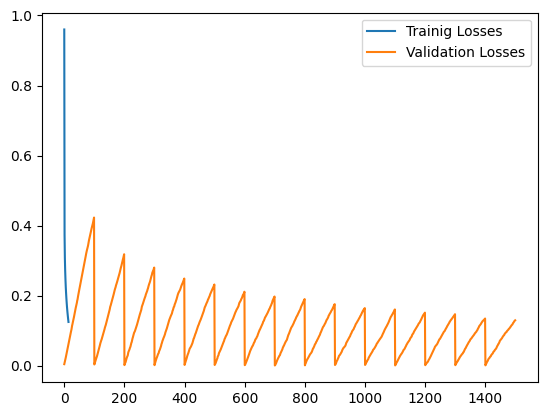

In [16]:
plt.plot(running_loss_history, label = 'Trainig Losses')
plt.plot(val_running_loss_history, label = 'Validation Losses')
plt.legend()
plt.show()

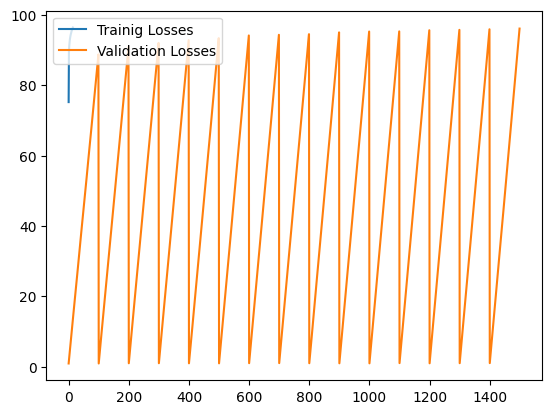

In [17]:
plt.plot(running_correct_history, label = 'Trainig Losses')
plt.plot(val_running_correct_history, label = 'Validation Losses')
plt.legend()
plt.show()

#### Test Model

In [18]:
import requests
import PIL.ImageOps
import PIL 
from PIL import Image

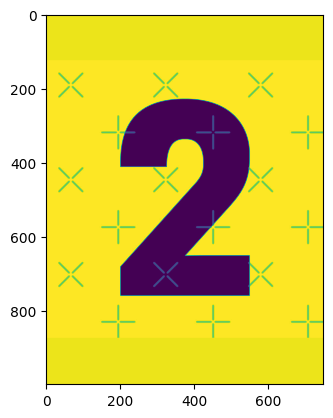

In [19]:
url = "https://ih1.redbubble.net/image.869970764.1635/flat,750x,075,f-pad,750x1000,f8f8f8.jpg"
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

## Image Processing
#### Image To be Feeded Must be Black white and black color 

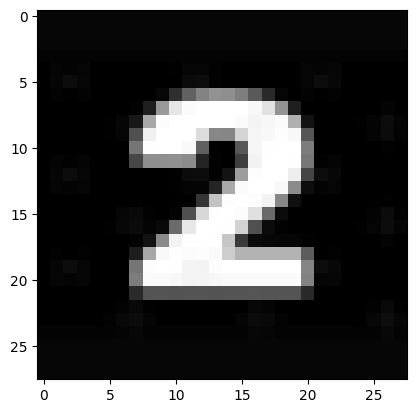

In [20]:
img = PIL.ImageOps.invert(img.convert('RGB'))
img =img.convert(mode ="L")
img = transform(img)
plt.imshow(im_convert(img))

#### Prediction

In [23]:
img = img.view(img.shape[0], -1) #(100, 784 = 28*28)
outputs = model(img)
_, pred = torch.max(outputs, 1)
print(pred.item())

2


In [24]:
images = vimages.view(vimages.shape[0], -1)
images.shape

torch.Size([100, 784])

ValueError: axes don't match array

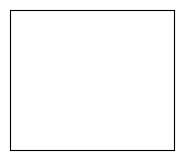

In [25]:
valdataIter = iter(validation_loader)
images, labels = next(valdataIter)
images = images.view(images.shape[0], -1)
outputs = model(images)
_, preds = torch.max(outputs, 1)

fig = plt.figure(figsize = (25, 4))
for idx in range(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(f' {str(preds[idx].item())} ( {str(labels[idx].item())} )', color = ('green' if preds[idx] == labels[idx] else 'red'))